In [1]:
import numpy as np

import scipy.io
import scipy.stats

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns 

import itertools

#extend notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:99.5% !important;} </style>"))

# from tslearn.metrics import dtw as time_warping

import ordpy
import tqdm
import igraph


from numpy import linalg as LA
from scipy.signal import find_peaks

In [2]:
#Statistical Learning
from sklearn.cluster import KMeans

#model selectionfrom sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import validation_curve
# from sklearn.model_selection import learning_curve
# from sklearn.model_selection import cross_val_score

#evaluation
# from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

#dimensionality reduction
from sklearn.decomposition import PCA
# from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from umap import UMAP

# Functions' definitions

In [3]:
def stdfigsize(scale=1, nrows=1, ncols=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.

    Parameters
    ----------
    returns (7*ratio*scale*nrows, 7.*scale*ncols)
    By default: ratio=1.3
    ----------
    Returns (7*ratio*scale*nrows, 7.*scale*ncols).
    """

    return((7*ratio*scale*ncols, 7.*scale*nrows))

In [4]:
%matplotlib inline

#Style definitions
sns.set_style("white")
sns.set_style({"xtick.direction": "out", "ytick.direction": "out"})

rcparams = {
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica'],
    'axes.labelsize': 28,
    'axes.titlesize': 28,
    'legend.fontsize': 20,
    'ytick.right': 'off',
    'xtick.top': 'off',
    'ytick.left': 'on',
    'xtick.bottom': 'on',
    'xtick.labelsize': '25',
    'ytick.labelsize': '25',
    'axes.linewidth': 2.5,
    'xtick.major.width': 1.8,
    'xtick.minor.width': 1.8,
    'xtick.major.size': 14,
    'xtick.minor.size': 7,
    'xtick.major.pad': 10,
    'xtick.minor.pad': 10,
    'ytick.major.width': 1.8,
    'ytick.minor.width': 1.8,
    'ytick.major.size': 14,
    'ytick.minor.size': 7,
    'ytick.major.pad': 10,
    'ytick.minor.pad': 10,
    'axes.labelpad': 15,
    'axes.titlepad': 15,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'figure.figsize': stdfigsize(),
    'lines.linewidth': 3
}
mpl.rcParams.update(rcparams)

In [5]:
def normalize(array):
    """
    Normalizes an array between 0 and 1.
    """
    return (array-array.min())/(array.max()-array.min())

In [6]:
#https://github.com/oliviaguest/gini
#last modified 31/05/2020
def gini_faster(data):
    """
    Calculate the Gini coefficient of a numpy array.
    (Allegedly faster implementation to calculate
    the Gini index.)
     
    Parameters
    ----------
    data: list like object.
    ----------
    Returns the Gini index of a list of probabilities.    
    """
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm

#Arthur (modified) line above
    array = np.asarray(data).flatten()
#     array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

def safe_avg_shortpath(ordnet):
    """
    Calculates the average weighted shortest 
    path for a graph removing possible
    infinities.
    
    Parameters
    ----------
    ordinal_network: return of the ordinal_network() function from the ordpy package.
    ----------
    Returns the average weighted shortest path
    calculated after the removal of eventual 
    infinities.
    """
    nodes, edges, weights = ordnet
    
    graph = igraph.Graph(directed=True)
    graph.add_vertices(nodes)
    graph.add_edges(edges)
    graph.vs["label"]  = nodes
    graph.es["weight"] = weights
    
    if not True in np.isinf(graph.shortest_paths(weights='weight')):
        w = np.asarray(graph.shortest_paths(weights='weight'))
        return w.mean()
    else:
        sp = np.asarray(graph.shortest_paths(weights='weight'))
        return np.mean(sp[sp<np.inf])

In [7]:
def full_ordinal_distribution(data, dx=3, taux=1, multi=False):
    """
    Ordinal probability distribution. Ordered and with 
    permutations with zero probability.
    
    Parameter
    ---------
    data : array
           Array object in the format :math:`[x_{1}, x_{2}, x_{3}, \\ldots ,x_{n}]`
           or  :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]`
           or an ordinal probability distribution (such as the ones returned by 
           `full_ordinal_distribution`).
    dx : int
         Embedding dimension (horizontal axis) (default: 3).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    multi : boolean
            If `True`, assumes **data** is multivariate time series. If 
            `False`, **data** is expected to be a one-dimensional 
            array (default: `False`). 
    ---------
     : tuple
       Tuple containing two arrays, one with the ordinal patterns occurring in data 
       and another with their corresponding probabilities.

    """
    if multi==False:
        try:
            ny, nx = np.shape(data)
            data   = np.array(data)
        except:
            nx     = np.shape(data)[0]
            ny     = 1
            data   = np.array([data])
            
        partitions = np.concatenate(
            [
                [np.concatenate(data[j:j+1:1,i:i+dx*taux:taux]) for i in range(nx-(dx-1)*taux)] 
                for j in range(ny)
            ]
        )

        symbols = np.apply_along_axis(np.argsort, 1, partitions)
        symbols, symbols_count = np.unique(symbols, return_counts=True, axis=0)

        probabilities = symbols_count/len(partitions)
        full_symbols  = np.asarray(list(itertools.permutations(np.arange(dx))))

        flat_symbols     = np.apply_along_axis(np.array2string, 1, symbols, separator='')
        full_symbols_str = np.apply_along_axis(np.array2string, 1, full_symbols, separator='')
        full_probs       = np.full(len(full_symbols), 0.)

        for symbol_, probs_ in zip(flat_symbols, probabilities):
            index             = np.argwhere(symbol_==full_symbols_str).flatten()
            full_probs[index] = probs_

        return full_symbols, full_probs
        
    else:
        try:
            ny, nx = np.shape(data)
            data   = np.array(data).T
        except:
            return None

        partitions                  = [np.concatenate([[component[i:i+dx*taux:taux]] for i in range(ny-(dx-1)*taux)]) for component in data]
        flat_symbolic_sequences     = np.apply_along_axis(np.argsort, 2, partitions).reshape(-1, dx)
        flat_symbols, symbols_count = np.unique(flat_symbolic_sequences, return_counts=True, axis=0)

        probabilities = symbols_count/symbols_count.sum()
        full_symbols  = np.asarray(list(itertools.permutations(np.arange(dx))))

        flat_symbols     = np.apply_along_axis(np.array2string, 1, flat_symbols, separator='')
        full_symbols_str = np.apply_along_axis(np.array2string, 1, full_symbols, separator='')
        full_probs       = np.full(len(full_symbols), 0.)

        for symbol_, probs_ in zip(flat_symbols, probabilities):
            index             = np.argwhere(symbol_==full_symbols_str).flatten()
            full_probs[index] = probs_

        return full_symbols, full_probs

In [8]:
def fisher_shannon(data, dx=3, taux=1, probs=False, multi=False):
    """
    Calculates permutation entropy\\ [#bandt_pompe]_ and Fisher 
    information using an ordinal distribution obtained from data.
    
    Parameters
    ----------
    data : array
           Array object in the format :math:`[x_{1}, x_{2}, x_{3}, \\ldots ,x_{n}]`
           or  :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]`
           or an ordinal probability distribution (such as the ones returned by 
           `full_ordinal_distribution`).
    dx : int
         Embedding dimension (horizontal axis) (default: 3).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    probs : boolean
            If `True`, assumes **data** is an ordinal probability distribution. If 
            `False`, **data** is expected to be a one- or two-dimensional 
            array (default: `False`). 
    multi : boolean
            If `True`, assumes **data** is multivariate time series. If 
            `False`, **data** is expected to be a one-dimensional 
            array (default: `False`). 

    Returns
    -------
     : tuple
       Values of permutation entropy and Fisher information.
    """  
    if multi==False:
        if probs==False:
            _, dist_ = full_ordinal_distribution(data, dx, taux)
            h_       = ordpy.permutation_entropy(dist_, dx, taux, probs=True)
        else:
            dist_    = data
            h_       = ordpy.permutation_entropy(dist_, dx, taux, probs=True)

        if dist_[0]==1. or dist_[-1]==1.: # F = F_0 \sum_{i = 1}^{N - 1} (\sqrt{p_{i+1}} - \sqrt{p_{i}})^2
            return h_, np.sum(np.diff(np.sqrt(dist_[::-1]))**2)  # with F_0=1
        else:
            return h_, 0.5*np.sum(np.diff(np.sqrt(dist_[::-1]))**2) # with F_0=1/2
        
    else:
        if probs==False:
            _, dist_ = full_ordinal_distribution(data, dx, taux, multi=True)
            h_       = ordpy.permutation_entropy(dist_, dx, taux, probs=True)
        else:
            dist_    = data
            h_       = ordpy.permutation_entropy(dist_, dx, taux, probs=True)

        if dist_[0]==1. or dist_[-1]==1.: # F = F_0 \sum_{i = 1}^{N - 1} (\sqrt{p_{i+1}} - \sqrt{p_{i}})^2
            return h_, np.sum(np.diff(np.sqrt(dist_[::-1]))**2) # with F_0=1
        else:
            return h_, 0.5*np.sum(np.diff(np.sqrt(dist_[::-1]))**2) # with F_0=1/2

In [9]:
def multi_permutation_entropy(data, dx=3, taux=1, base=2, normalized=True, return_probs=False):
    """
    Calculates Shannon's entropy using an ordinal ditribution extracted from
    data (a multidimensional time series).
    
    Parameters
    ----------
    data : array
           Array object in the format :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]` where n is the length 
           and m is the dimension of a multidimensional time series.
    dx : int
         Embedding dimension (horizontal axis) (default: 3)
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    base : str, int
           Logarithm base in Shannon's entropy. Either 'e' or 2 (default: 'e').
    normalized: boolean
                If `True`, permutation entropy is normalized by its maximum value.
                If `False`, it does not (default: `True`).

    Returns
    -------
     : float
       The value of permutation entropy.
    
    Examples
    --------
    """
    try:
        ny, nx = np.shape(data)
        data   = np.array(data).T
    except:
        return None
    
    partitions                  = [np.concatenate([[component[i:i+dx*taux:taux]] for i in range(ny-(dx-1)*taux)]) for component in data]
    flat_symbolic_sequences     = np.apply_along_axis(np.argsort, 2, partitions).reshape(-1, dx)
    flat_symbols, symbols_count = np.unique(flat_symbolic_sequences, return_counts=True, axis=0)

    probabilities = symbols_count/symbols_count.sum()

    if return_probs==True:
        miss_symbols  = np.math.factorial(dx)-len(probabilities)
        probabilities = np.concatenate((probabilities, np.zeros(miss_symbols)))
        
        return probabilities
    
    else:
        if normalized==True and base in [2, '2']:        
            smax = np.log2(np.math.factorial(dx))
            s    = -np.sum(probabilities*np.log2(probabilities))
            return s/smax

        elif normalized==True and base=='e':        
            smax = np.log(np.math.factorial(dx))
            s    = -np.sum(probabilities*np.log(probabilities))
            return s/smax

        elif normalized==False and base in [2, '2']:
            return -np.sum(probabilities*np.log2(probabilities))

        else:
            return -np.sum(probabilities*np.log(probabilities))

In [10]:
def mwpe(data, dx=3, taux=1, base=2, normalized=True, return_probs=False):
    """
    Multivariate weighted permutation entropy.
    
    Parameters
    ----------
    data : array
           Array object in the format :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]` where n is the length 
           and m is the dimension of a multidimensional time series.
    dx : int
         Embedding dimension (horizontal axis) (default: 3)
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    base : str, int
           Logarithm base in Shannon's entropy. Either 'e' or 2 (default: 'e').
    normalized: boolean
                If `True`, permutation entropy is normalized by its maximum value.
                If `False`, it does not (default: `True`).

    Returns
    -------
     : float
       The value of permutation entropy.
    
    Examples
    --------
    """
    try:
        ny, nx = np.shape(data)
        data   = np.array(data).T
    except:
        return None
    
    partitions              = np.asarray([np.concatenate([[component[i:i+dx*taux:taux]] for i in range(ny-(dx-1)*taux)]) for component in data])
    weights                 = partitions.var(axis=2).flatten()
    flat_symbolic_sequences = np.apply_along_axis(np.argsort, 2, partitions).reshape(-1, dx)
    symbols                 = np.unique(flat_symbolic_sequences, return_counts=False, axis=0)


    total_variance = []
    for symbol in symbols:
        z    = flat_symbolic_sequences==symbol
        z    = z.sum(axis=1)
        args = np.argwhere(z==dx).flatten()
        
        total_variance.append(sum(weights[args]))

    probabilities = total_variance/sum(total_variance)
    
    if return_probs==True:
        miss_symbols  = np.math.factorial(dx)-len(probabilities)
        probabilities = np.concatenate((probabilities, np.zeros(miss_symbols)))
        
        return probabilities
    
    else:
        if normalized==True and base in [2, '2']:        
            smax = np.log2(np.math.factorial(dx))
            s    = -np.sum(probabilities*np.log2(probabilities))
            return s/smax

        elif normalized==True and base=='e':        
            smax = np.log(np.math.factorial(dx))
            s    = -np.sum(probabilities*np.log(probabilities))
            return s/smax

        elif normalized==False and base in [2, '2']:
            return -np.sum(probabilities*np.log2(probabilities))

        else:
            return -np.sum(probabilities*np.log(probabilities))   

In [11]:
def weighted_permutation_entropy(data, dx=3, taux=1, base=2, normalized=True):
    """
    Multivariate weighted permutation entropy.
    
    Parameters
    ----------
    data : array
           Array object in the format :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]` where n is the length 
           and m is the dimension of a multidimensional time series.
    dx : int
         Embedding dimension (horizontal axis) (default: 3)
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    base : str, int
           Logarithm base in Shannon's entropy. Either 'e' or 2 (default: 'e').
    normalized: boolean
                If `True`, permutation entropy is normalized by its maximum value.
                If `False`, it does not (default: `True`).

    Returns
    -------
     : float
       The value of permutation entropy.
    
    Examples
    --------
    """
    data   = np.asarray(data)
    
    partitions              = np.asarray([np.concatenate([[component[i:i+dx*taux:taux]] for i in range(ny-(dx-1)*taux)]) for component in data])
    weights                 = partitions.var(axis=2).flatten()
    flat_symbolic_sequences = np.apply_along_axis(np.argsort, 2, partitions).reshape(-1, dx)
    symbols                 = np.unique(flat_symbolic_sequences, return_counts=False, axis=0)


    total_variance = []
    for symbol in symbols:
        z    = flat_symbolic_sequences==symbol
        z    = z.sum(axis=1)
        args = np.argwhere(z==dx).flatten()
        
        total_variance.append(sum(weights[args]))

    probabilities = total_variance/sum(total_variance)
    
    if return_probs==True:
        miss_symbols  = np.math.factorial(dx)-len(probabilities)
        probabilities = np.concatenate((probabilities, np.zeros(miss_symbols)))
        
        return probabilities
    
    else:
        if normalized==True and base in [2, '2']:        
            smax = np.log2(np.math.factorial(dx))
            s    = -np.sum(probabilities*np.log2(probabilities))
            return s/smax

        elif normalized==True and base=='e':        
            smax = np.log(np.math.factorial(dx))
            s    = -np.sum(probabilities*np.log(probabilities))
            return s/smax

        elif normalized==False and base in [2, '2']:
            return -np.sum(probabilities*np.log2(probabilities))

        else:
            return -np.sum(probabilities*np.log(probabilities))   

In [12]:
def trajectory_cleaning(shape):
    """
    Cleans and segments the original trajectories of falling papers
    using the data and parameters established by Howison et al., 
    Nature Machine Intelligence 2, 68–75(2020).
    
    Parameters
    ----------
    shape (str): shape of falling paper. Either "Circle", 
                 "Square" or "Cross".
    ----------
    Returns several arrays or floats containing time series
    or characteristics of the falling papers:
    
    - series of tridimensional trajectories; 
    - series of observable area (camera 1); 
    - series of observable area (camera 2);
    - radii of falling paper shape;
    - width of falling paper shape (in case shape=="Cross");
    - initial condition (0 for robotic arm horizontal position,
    1 for vertical position);
    - preclassification of cleaned trajectories (3 for periodic falling and nan 
    for possibly chaotic or tumbling time series).
                         
    References
    ----------
    Howison et al., Large-scale automated investigation of free-falling paper shapes 
    via physical experimentation, Nature Machine Intelligence 2, 68–75 (2020).
    
    """
    ##########################################################################################
    #Data processing

    #Improving data structure. Extracting data from data{shape}.mat and loading it into data arrays
    disk_data = scipy.io.loadmat('classification/data{}.mat'.format(shape))

    #initial condition of the experiments: 0 (dropping with arm holding the paper horizontally) or 1 (dropping vertically)
    disk_initcons = []
    for i in range(len(disk_data['data'][0])):
        disk_initcons.append(disk_data['data'][0][i]['initialCondition'][0][0][0][0])
    disk_initcons = np.asarray(disk_initcons)

    # radii of the disks dropped
    disk_radii = []
    for i in range(len(disk_data['data'][0])):
        disk_radii.append(disk_data['data'][0][i]['radius'][0][0][0][0])
    disk_radii = np.asarray(disk_radii)

    # width of the crosses dropped
    if shape=='Cross':
        disk_width = []
        for i in range(len(disk_data['data'][0])):
            disk_width.append(disk_data['data'][0][i]['width'][0][0][0][0])
        disk_width = np.asarray(disk_width)

    # camera 1 observable area?
    disk_cam1 = []
    for i in range(len(disk_data['data'][0])):
        disk_cam1.append(disk_data['data'][0][i]['areaCam1'][0][0].flatten())
    disk_cam1 = np.asarray(disk_cam1)

    # camera 2 observable area?
    disk_cam2 = []
    for i in range(len(disk_data['data'][0])):
        disk_cam2.append(disk_data['data'][0][i]['areaCam2'][0][0].flatten())
    disk_cam2 = np.asarray(disk_cam2)

    # coordinates (x, y, z) along trajectory from 1m high to the floor.
    disk_trajectories = []
    for i in range(len(disk_data['data'][0])):
        disk_trajectories.append(disk_data['data'][0][i]['trajectory'][0][0])
    disk_trajectories = np.asarray(disk_trajectories)
    ##########################################################################################

    
    #Cleaning trajectories
    clean_disk_trajectories = []
    clean_disk_cam2         = []
    clean_disk_cam1         = []
    
    clean_disk_initcons     = []
    clean_disk_class        = []
    clean_disk_radii        = []
    clean_disk_width        = []

    for i in range(len(disk_trajectories)):
        #vertical trajectory
        z         = disk_trajectories[i][::,2][::-1]

        #finding the index to remove the last 5cm of fall
        cut_index = 0
        for z_ in z:
            if z_<0.05:
                cut_index -= 1
            else: break

        if not cut_index==0:
            # removing the last 5 centimeters of the fall.
            trajectory = disk_trajectories[i][:cut_index].copy() 

            #removing  the last 5cm of fall from observable area series
            area_cam2 = disk_cam2[i][:cut_index].copy()
            area_cam1 = disk_cam1[i][:cut_index].copy()
        else:
            trajectory = disk_trajectories[i].copy() 
            area_cam2  = disk_cam2[i].copy()
            area_cam1  = disk_cam1[i].copy()


    #(original comment) Segment steady and periodic behaviours from trajectories. 
        if disk_initcons[i]==0: #(original comment) We only see steady and periodic from horizontal initial condition.
            tc=0
            while np.sqrt(trajectory[::,0][tc]**2 + trajectory[::,1][tc]**2)<(0.2*disk_radii[i]) and tc<len(trajectory[::,1]):
                tc=tc+1

            if tc>1: #(original comment) Segment trajectory into steady(periodic)/unknown if more than 2 time-steps are steady(periodic)
    #             pass
    #             print(steady_index)
                clean_disk_trajectories.append(trajectory[:tc+1])
                clean_disk_initcons.append(0)
                clean_disk_radii.append(disk_radii[i])
                clean_disk_class.append(3)
                clean_disk_cam1.append(area_cam1[:tc+1]) #slicing in Python is exclusive: [start: end), therefore, we sum 1 to tc.
                clean_disk_cam2.append(area_cam2[:tc+1]) #slicing in Python is exclusive: [start: end), therefore, we sum 1 to tc.
                # width of the crosses dropped
                if shape=='Cross':
                    clean_disk_width.append(disk_width[i])
                else: pass
    #             print('dividiu: ', i)
    #             print('counter steady:', counter)

                if len(trajectory)-tc>10: #second part of the sliced original trajectory.
                    clean_disk_trajectories.append(trajectory[tc:])
                    clean_disk_initcons.append(0)
                    clean_disk_radii.append(disk_radii[i])
                    clean_disk_class.append(np.nan)
                    clean_disk_cam1.append(area_cam1[tc:])
                    clean_disk_cam2.append(area_cam2[tc:])
                    # width of the crosses dropped
                    if shape=='Cross':
                        clean_disk_width.append(disk_width[i])
                    else: pass

            else: #no segmentation; only one behavior throughout the whole fall
                clean_disk_trajectories.append(trajectory)
                clean_disk_initcons.append(0)
                clean_disk_radii.append(disk_radii[i])
                clean_disk_class.append(np.nan)
                clean_disk_cam1.append(area_cam1)
                clean_disk_cam2.append(area_cam2)
                # width of the crosses dropped
                if shape=='Cross':
                    clean_disk_width.append(disk_width[i])
                else: pass


        else: #(original comment) Vertical initial condition, no steady and peridoic behaviour
            tc = 0
            while np.sqrt(trajectory[::,0][tc]**2 + trajectory[::,1][tc]**2)<0.01 and tc<len(trajectory[::,1]):
                tc = tc+1

            if len(trajectory[::,1])-tc>10:
                clean_disk_trajectories.append(trajectory[tc:])
                clean_disk_initcons.append(1)
                clean_disk_radii.append(disk_radii[i])
                clean_disk_class.append(np.nan)
                clean_disk_cam1.append(area_cam1[tc:])
                clean_disk_cam2.append(area_cam2[tc:])
                # width of the crosses dropped
                if shape=='Cross':
                    clean_disk_width.append(disk_width[i])
                else: pass

    if shape=='Cross':
        return  clean_disk_trajectories, clean_disk_cam1, clean_disk_cam2, clean_disk_radii, clean_disk_width, clean_disk_initcons, clean_disk_class
    else:
        return  clean_disk_trajectories, clean_disk_cam1, clean_disk_cam2, clean_disk_radii, clean_disk_initcons, clean_disk_class

In [13]:
def original_features(trajectories, area_cam1, area_cam2):
    """
    Extracts physical measures from time series of 
    falling paper. For more information, see Howison et al., 
    Nature Machine Intelligence 2, 68–75(2020).
    
    Parameters
    ----------
    trajectories (array): set of time series of  trajectories of 
                          falling papers.
    ----------
    Returns several arrays containing 
    characteristics of falling papers:
    
    - displacement in the x axis; 
    - displacement in the y axis; 
    - displacement in the z axis; 
    - length of the trajectory;
    - duration of the fall;
    - angular velocity;
    - standard deviation of the velocity of fall
    in the z axis;
        
    References
    ----------
    Howison et al., Large-scale automated investigation of free-falling paper shapes 
    via physical experimentation, Nature Machine Intelligence 2, 68–75 (2020).
    
    """
    clean_disk_trajectories = trajectories
    clean_disk_cam1         = area_cam1
    clean_disk_cam2         = area_cam2
    
    dx         = []
    dy         = []
    dz         = []
    pathlength = []
    time       = []
#     X          = []
    Osc        = []
    SpeedZ     = []
    
    for i in range(len(clean_disk_trajectories)):
        stop = 0
        d    = 0 

        for j in range(1, len(clean_disk_trajectories[i])):
            if LA.norm(clean_disk_trajectories[i][j]-clean_disk_trajectories[i][j-1])>0.1:
                stop==1
                break
            d = d + LA.norm(clean_disk_trajectories[i][j]-clean_disk_trajectories[i][j-1])

        if stop==0:
            pathlength.append(d)
            z = clean_disk_trajectories[i][::,2]
            dz.append(np.absolute(clean_disk_trajectories[i][::,2][-1]-clean_disk_trajectories[i][::,2][0]))
            dy.append(clean_disk_trajectories[i][::,1][-1]-clean_disk_trajectories[i][::,1][0])
            dx.append(clean_disk_trajectories[i][::,0][-1]-clean_disk_trajectories[i][::,0][0])
            time.append(len(clean_disk_trajectories[i])*1/98)

            locs1 = find_peaks(clean_disk_cam1[i])[0]
            locs2 = find_peaks(clean_disk_cam2[i])[0]

            Osc.append((len(locs1)+len(locs2))/(2*time[-1]))
            SpeedZ.append(np.std(np.diff(z)))
#             X.append([Osc, SpeedZ])

    return dx, dy, dz, pathlength, time, Osc, SpeedZ

# Disks

In [14]:
shape_ = 'Circle'

#loading cleaned trajectories and some features.
circle_trajectories, circle_cam1, circle_cam2, circle_radius, circle_conditions, _ = trajectory_cleaning(shape_)
circle_dx, circle_dy, circle_dz, circle_pathlen, circle_time, circle_w, circle_vz  = original_features(circle_trajectories, circle_cam1, circle_cam2)

/home/arthur/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [15]:
#Classifications
disk_human_class = scipy.io.loadmat('classification/humanClassification{}.mat'.format('Circle'))['behaviourHuman'][0]
disk_feat_class  = scipy.io.loadmat('classification/data{}Classified.mat'.format('Circle'))['behaviourAuto'].flatten()

#Mapping from integer to behavior class
# 1 - Tumbling
# 2 - Chaotic
# 3 - Steady or periodic behavior

In [31]:
# for a, b, c, d, e, f, g,  k in zip(scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['dx'].flatten()==np.asarray(circle_dx), 
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['dy'].flatten()==np.asarray(circle_dy), 
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['dz'].flatten()==np.asarray(circle_dz), 
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['pathLength'].flatten(), circle_pathlen,
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['time'].flatten(), circle_time,
#                             range(len(circle_dx))):

#     print(a, b, c, abs(d-e)<0.0001, abs(f-g)<0.0001, k)

## Original features plane

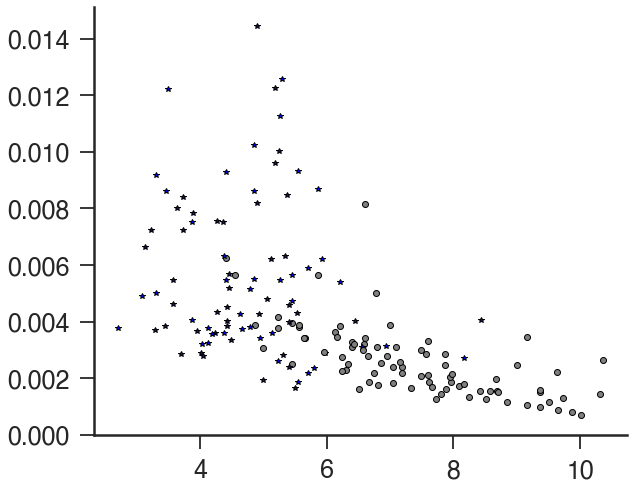

In [44]:
f, ax = plt.subplots()

for osc, vz, class_ in zip(circle_w, circle_vz, disk_human_class):
    if class_==1:
        ax.plot(osc, vz, 'o', markeredgecolor='black', color='grey')
    elif class_==2:
        ax.plot(osc, vz, '*', markeredgecolor='black', color='blue')
    else:
        pass
#         ax.plot(osc, vz, 's', markeredgecolor='black', color='red')
    
f.tight_layout()

## Complexity-entropy or Fisher-Shannon plane

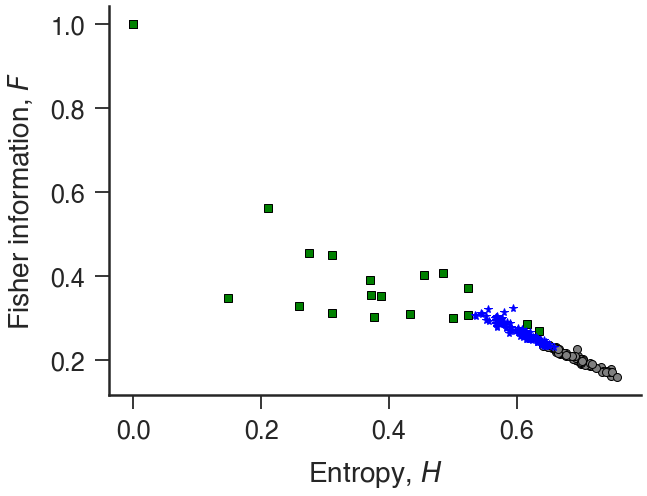

In [80]:
dx_  = 3

disk_ce    = []
disk_plane = []
for i, st, ts1, ts2, class_ in zip(range(len(circle_trajectories)), circle_trajectories, 
                                   circle_cam1, circle_cam2, disk_feat_class):
    if class_==3:
        try:
            ts = np.stack((normalize(ts1), normalize(ts2)), axis=1)
            disk_ce.append(fisher_shannon(ts, dx=dx_, multi=True))
        except:
            disk_ce.append((np.nan, np.nan))
    else:

        ts = np.stack((normalize(ts1), normalize(ts2)), axis=1)
        disk_ce.append(fisher_shannon(ts, dx=dx_, multi=True))
        disk_plane.append(fisher_shannon(ts, dx=dx_, multi=True))


#         p  = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
#         disk_ce.append(ordpy.complexity_entropy(p, dx=dx_, probs=True))
        
        
#         disk_ce.append(fisher_shannon(normalize(ts1), dx=dx_, multi=False))


f, ax = plt.subplots()

for (h_, c_), class_ in zip(disk_ce, disk_feat_class): 
# for (h_, c_), class_ in zip(disk_ce, disk_human_class):
    if class_ == 1: #tumbling
        ax.plot(h_, c_, '.', marker='o', markersize=8, markeredgecolor='black', color='grey', zorder=0)
    elif class_ == 2: #chaotic
        ax.plot(h_,c_,  '.', marker='*', markersize=8, color='blue')
    if class_ == 3:
        try:
            ax.plot(h_,c_,  '.', marker='s', markersize=8, markeredgecolor='black', color='green', zorder=0)
        except:
            pass

ax.set_ylabel('Fisher information, $F$')
ax.set_xlabel('Entropy, $H$')

f.tight_layout()
# f.savefig('figures/auto-Fisher/Fisher-{}-dx:{}-dims:{}'.format(shape, dx_, dims), bbox_inches='tight')

In [82]:
disk_plane = np.asarray(disk_plane).reshape(-1,2)
Y_pred       = KMeans(n_clusters=2, random_state=42).fit(disk_plane).labels_

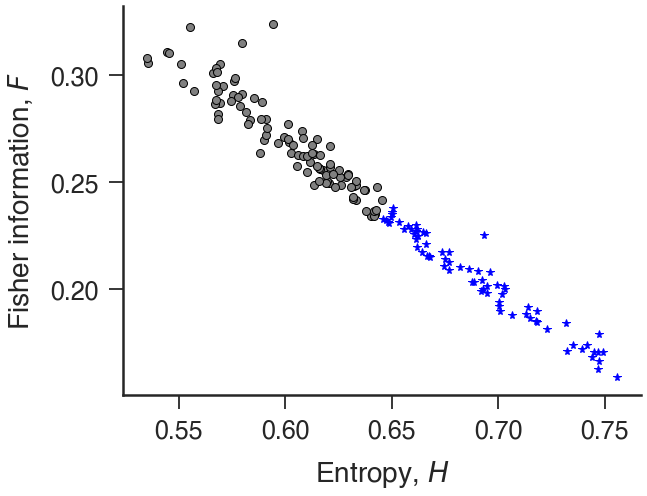

In [83]:
f, ax = plt.subplots()

for (h_, c_), class_ in zip(disk_plane, Y_pred):
    if class_==0:
        ax.plot(h_, c_, '.', marker='o', markersize=8, markeredgecolor='black', color='grey', zorder=0)
    else:
        ax.plot(h_,c_,  '.', marker='*', markersize=8, color='blue')
        
ax.set_ylabel('Fisher information, $F$')
ax.set_xlabel('Entropy, $H$')

f.tight_layout()

In [84]:
Y_pred_full = disk_feat_class.copy()
y_pred_sub  = np.where(Y_pred==0, 2, Y_pred)

k = 0
for i, j in zip(disk_feat_class, range(len(disk_feat_class))):
    if i==3:
        pass
    else:
        Y_pred_full[j] = y_pred_sub[k]
        k += 1

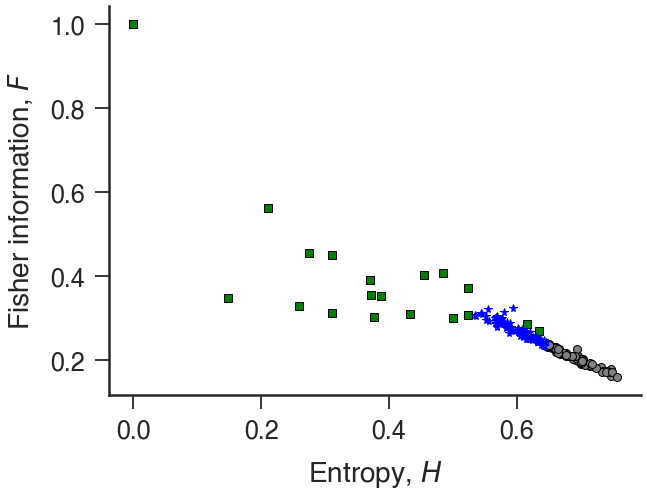

In [85]:
f, ax = plt.subplots()

# for (h_, c_), class_ in zip(square_ce, square_feat_class): 

for (h_, c_), class_ in zip(disk_ce, Y_pred_full):
    if class_ == 1: #tumbling
        ax.plot(h_, c_, '.', marker='o', markersize=8, markeredgecolor='black', color='grey', zorder=0)
    elif class_ == 2: #chaotic
        ax.plot(h_,c_,  '.', marker='*', markersize=8, color='blue')
    if class_ == 3:
        try:
            ax.plot(h_,c_,  '.', marker='s', markersize=8, markeredgecolor='black', color='green', zorder=0)
        except:
            pass

ax.set_ylabel('Fisher information, $F$')
ax.set_xlabel('Entropy, $H$')

f.tight_layout()

In [86]:
sum(disk_feat_class==disk_human_class)/len(disk_human_class)

0.8853211009174312

In [87]:
sum(Y_pred_full==disk_human_class)/len(disk_human_class)

0.908256880733945

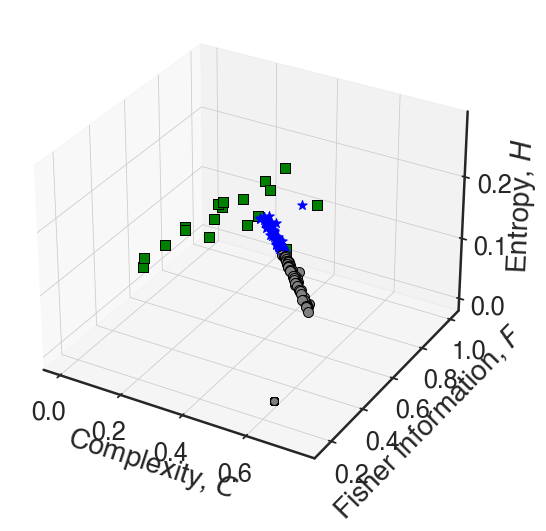

In [180]:
dx_ = 3

pe3d       = []
pe3d_plane = []

for i, st, ts1, ts2, class_ in zip(range(len(circle_trajectories)), circle_trajectories, 
                                   circle_cam1, circle_cam2, disk_feat_class):
    if class_==3:
        try:
            ts = np.stack((normalize(ts1), normalize(ts2)), axis=1)
            p  = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
            h_, f_ = fisher_shannon(p, dx=dx_, probs=True, multi=True)
            _, c_  = ordpy.complexity_entropy(p, dx=dx_, probs=True)
            pe3d.append((h_, f_, c_))
        except:
            disk_ce.append((np.nan, np.nan))
    else:

        ts = np.stack((normalize(ts1), normalize(ts2)), axis=1)
        p  = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
        h_, f_ = fisher_shannon(p, dx=dx_, probs=True, multi=True)
        _, c_  = ordpy.complexity_entropy(p, dx=dx_, probs=True)
        pe3d.append((h_, f_, c_))
        pe3d_plane.append((h_, f_, c_))

f  = plt.figure()
ax = f.add_subplot(111, projection='3d')

#(h_, f_, c_)
for (x_, y_, z_), class_ in zip(pe3d, disk_feat_class): 
# for (h_, c_), class_ in zip(disk_ce, disk_human_class):
    if class_ == 1: #tumbling
        ax.scatter(x_, y_, z_, marker='o', s=100, color='grey', edgecolor='black')
        ax.plot(h_, c_, '.', marker='o', markersize=8, markeredgecolor='black', color='grey', zorder=0)
    elif class_ == 2: #chaotic
        ax.scatter(x_, y_, z_, marker='*', s=100, color='blue')        
    if class_ == 3:
        try:
            ax.scatter(x_, y_, z_, marker='s', s=100, color='green', edgecolor='black', zorder=0)
        except:
            pass

ax.set_ylabel('Fisher information, $F$')
ax.set_xlabel('Complexity, $C$')
ax.set_zlabel('Entropy, $H$')

f.tight_layout()

In [173]:
pe3d_plane = np.asarray(pe3d_plane).reshape(-1,3)
Y_pred     = KMeans(n_clusters=2, random_state=42).fit(pe3d_plane).labels_

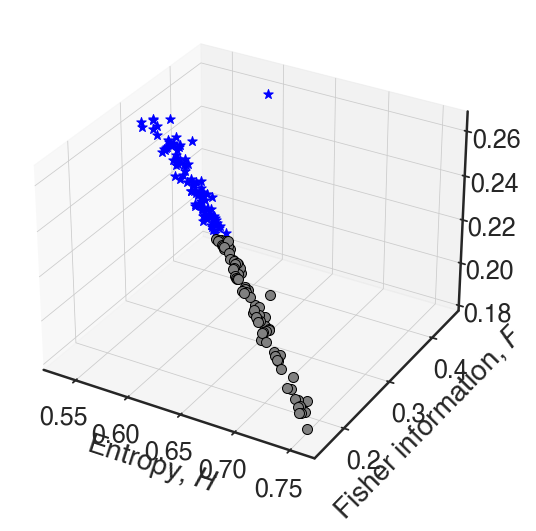

In [175]:
f  = plt.figure()
ax = f.add_subplot(111, projection='3d')


#(h_, f_, c_)
for (h_, f_, c_), class_ in zip(pe3d_plane, Y_pred): 
    if class_==0:
        ax.scatter(h_, f_, c_, marker='o', s=100, edgecolor='black', color='grey', zorder=0)
    else:
        ax.scatter(h_, f_, c_, marker='*', s=100, color='blue')
        
ax.set_ylabel('Fisher information, $F$')
ax.set_xlabel('Entropy, $H$')

f.tight_layout()

In [183]:
Y_pred_full = disk_feat_class.copy()
y_pred_sub  = Y_pred+1
# y_pred_sub  = np.where(Y_pred==0, 2, Y_pred)

k = 0
for i, j in zip(disk_feat_class, range(len(disk_feat_class))):
    if i==3:
        pass
    else:
        Y_pred_full[j] = y_pred_sub[k]
        k += 1

In [185]:
sum(disk_feat_class==disk_human_class)/len(disk_human_class)

0.8853211009174312

In [184]:
sum(Y_pred_full==disk_human_class)/len(disk_human_class)

0.908256880733945

## Dimensionality reduction

In [32]:
dx_     = 3
disk_ce = []

circle_series_distributions = []
for i, ts1, ts2, class_ in zip(range(len(circle_cam1)), circle_cam1, 
                                   circle_cam2, disk_feat_class):
    ts = np.stack((normalize(ts1), normalize(ts2)), axis=1)
    circle_series_distributions.append(full_ordinal_distribution(ts, dx=dx_, multi=True)[1])

In [78]:
X = circle_series_distributions
Y = disk_human_class

npca       = 3
# X_pca      = TSNE(n_components=npca, perplexity=5).fit_transform(X)

# X_pca      = UMAP(n_neighbors=10, n_components=npca).fit_transform(X)

fitted_pca = PCA(n_components=npca).fit(X)
X_pca      = fitted_pca.transform(X)
fitted_pca.explained_variance_ratio_.sum()

0.9975994574535719

In [79]:
Y_pred = KMeans(n_clusters=2, random_state=42).fit(X_pca).labels_

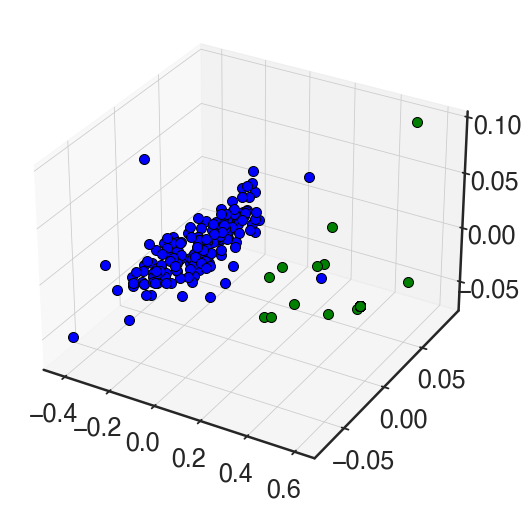

In [80]:
f = plt.figure()
ax  = f.add_subplot(111, projection='3d')

xyz = X_pca

for (x_, y_, z_), class_ in zip(xyz, Y_pred):
    if class_==0:
        ax.scatter(x_, y_, z_, marker='o', s=100, color='blue', edgecolor='black')
    elif class_==1:
        ax.scatter(x_, y_, z_, marker='o', s=100, color='green', edgecolor='black')        
    else:
        ax.scatter(x_, y_, z_, marker='o', s=100, color='black', edgecolor='black')

# ax.set_ylabel("PCA 2")
# ax.set_xlabel("PCA 1")
# ax.set_zlabel('PCA 3')

f.tight_layout()
# f.savefig()

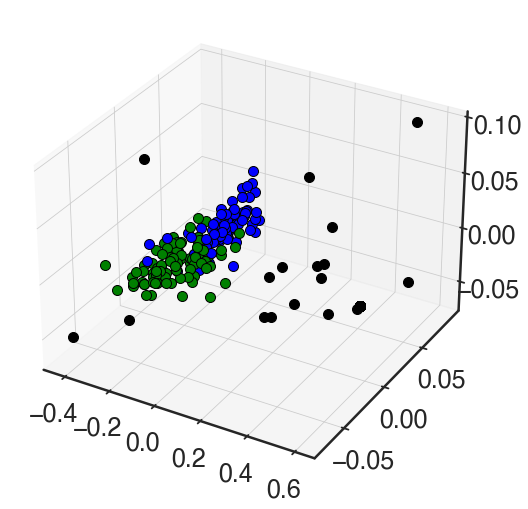

In [62]:
f = plt.figure()
ax  = f.add_subplot(111, projection='3d')

xyz = X_pca

for (x_, y_, z_), class_ in zip(xyz, Y):
    if class_==1:
        ax.scatter(x_, y_, z_, marker='o', s=100, color='blue', edgecolor='black')
    elif class_==2:
        ax.scatter(x_, y_, z_, marker='o', s=100, color='green', edgecolor='black')        
    else:
        ax.scatter(x_, y_, z_, marker='o', s=100, color='black', edgecolor='black')

# ax.set_ylabel("PCA 2")
# ax.set_xlabel("PCA 1")
# ax.set_zlabel('PCA 3')

f.tight_layout()
# f.savefig()

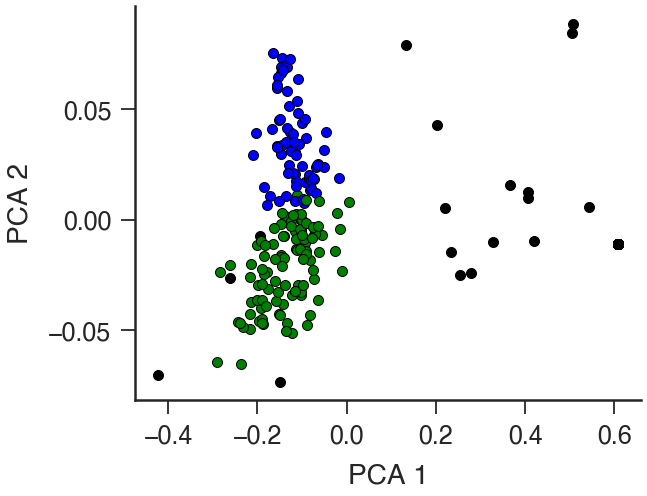

In [82]:
X = circle_series_distributions
Y = disk_feat_class

npca       = 2
# X_pca      = TSNE(n_components=npca, perplexity=5).fit_transform(X)
# X_pca      = UMAP(n_neighbors=3, n_components=npca).fit_transform(X)

fitted_pca = PCA(n_components=npca).fit(X)
X_pca      = fitted_pca.transform(X)
fitted_pca.explained_variance_ratio_.sum()

f, ax = plt.subplots()

xy = X_pca

for (x_, y_), class_ in zip(xy, Y):
    if class_==1:
        ax.scatter(x_, y_, marker='o', s=100, color='blue', edgecolor='black')
    elif class_==2:
        ax.scatter(x_, y_, marker='o', s=100, color='green', edgecolor='black')        
    else:
        ax.scatter(x_, y_, marker='o', s=100, color='black', edgecolor='black')

ax.set_ylabel("PCA 2")
ax.set_xlabel("PCA 1")

f.tight_layout()

In [84]:
Y_pred = KMeans(n_clusters=2, random_state=42).fit(X_pca[Y != 3]).labels_

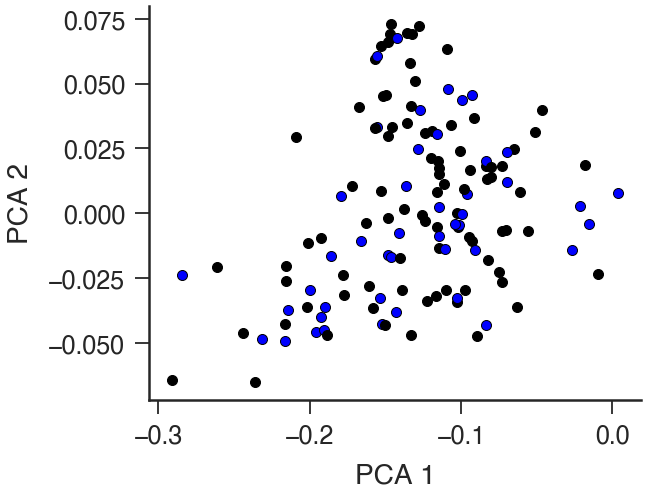

In [85]:
f, ax = plt.subplots()

xy = X_pca

for (x_, y_), class_, auto in zip(xy, Y_pred, Y):
    if auto==3: pass
    
    else:
        if class_==1:
            ax.scatter(x_, y_, marker='o', s=100, color='blue', edgecolor='black')
        elif class_==2:
            ax.scatter(x_, y_, marker='o', s=100, color='green', edgecolor='black')        
        else:
            ax.scatter(x_, y_, marker='o', s=100, color='black', edgecolor='black')

ax.set_ylabel("PCA 2")
ax.set_xlabel("PCA 1")

f.tight_layout()

# Squares

In [16]:
#loading cleaned trajectories and some features.
square_trajectories, square_cam1, square_cam2, square_radii, square_conditions, _ = trajectory_cleaning('Square')
square_dx, square_dy, square_dz, square_pathlen, square_time, square_w, square_vz  = original_features(square_trajectories, square_cam1, square_cam2)

In [17]:
#Classifications
square_human_class = scipy.io.loadmat('classification/humanClassification{}.mat'.format('Square'))['behaviourHuman'][0]
square_feat_class  = scipy.io.loadmat('classification/data{}Classified.mat'.format('Square'))['behaviourAuto'].flatten()

#Mapping from integer to behavior class
# 1 - Tumbling
# 2 - Chaotic
# 3 - Steady or periodic behavior

In [37]:
# for a, b, c, d, e, f, g,  k in zip(scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['dx'].flatten()==np.asarray(square_dx), 
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['dy'].flatten()==np.asarray(square_dy), 
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['dz'].flatten()==np.asarray(square_dz), 
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['pathLength'].flatten(), square_pathlen,
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['time'].flatten(), square_time,
#                             range(len(square_dx))):

#     print(a, b, c, abs(d-e)<0.0001, abs(f-g)<0.0001, k)

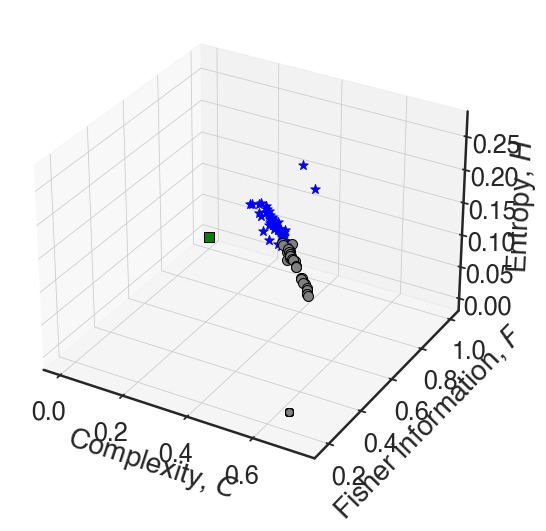

In [207]:
dx_ = 3

pe3d       = []
pe3d_plane = []

for i, st, ts1, ts2, class_ in zip(range(len(square_trajectories)), square_trajectories, 
                                   square_cam1, square_cam2, square_feat_class):
    if class_==3:
        try:
            ts = np.stack((normalize(ts1), normalize(ts2)), axis=1)
            p  = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
            h_, f_ = fisher_shannon(p, dx=dx_, probs=True, multi=True)
            _, c_  = ordpy.complexity_entropy(p, dx=dx_, probs=True)
            pe3d.append((h_, f_, c_))
        except:
            square_ce.append((np.nan, np.nan))
    else:

        ts = np.stack((normalize(ts1), normalize(ts2)), axis=1)
        p  = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
        h_, f_ = fisher_shannon(p, dx=dx_, probs=True, multi=True)
        _, c_  = ordpy.complexity_entropy(p, dx=dx_, probs=True)
        pe3d.append((h_, f_, c_))
        pe3d_plane.append((h_, f_, c_))

f  = plt.figure()
ax = f.add_subplot(111, projection='3d')

#(h_, f_, c_)
for (x_, y_, z_), class_ in zip(pe3d, square_feat_class): 
# for (x_, y_, z_), class_ in zip(pe3d, square_human_class):
    if class_ == 1: #tumbling
        ax.scatter(x_, y_, z_, marker='o', s=100, color='grey', edgecolor='black')
        ax.plot(h_, c_, '.', marker='o', markersize=8, markeredgecolor='black', color='grey', zorder=0)
    elif class_ == 2: #chaotic
        ax.scatter(x_, y_, z_, marker='*', s=100, color='blue')        
    if class_ == 3:
        try:
            ax.scatter(x_, y_, z_, marker='s', s=100, color='green', edgecolor='black', zorder=0)
        except:
            pass

ax.set_ylabel('Fisher information, $F$')
ax.set_xlabel('Complexity, $C$')
ax.set_zlabel('Entropy, $H$')

f.tight_layout()

In [208]:
pe3d_plane = np.asarray(pe3d_plane).reshape(-1, 3)
Y_pred     = KMeans(n_clusters=2, random_state=42).fit(pe3d_plane).labels_

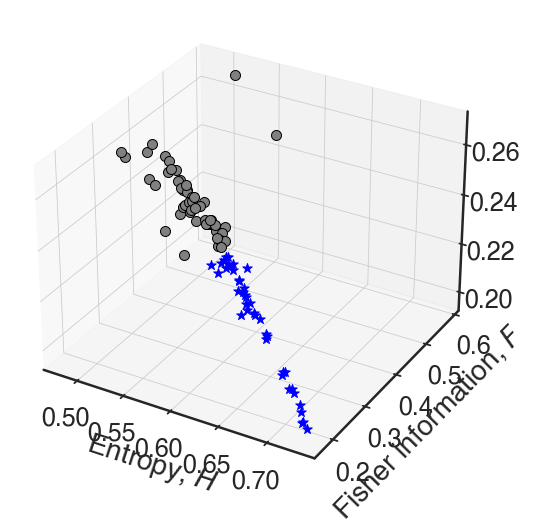

In [209]:
f  = plt.figure()
ax = f.add_subplot(111, projection='3d')


#(h_, f_, c_)
for (h_, f_, c_), class_ in zip(pe3d_plane, Y_pred): 
    if class_==0:
        ax.scatter(h_, f_, c_, marker='o', s=100, edgecolor='black', color='grey', zorder=0)
    else:
        ax.scatter(h_, f_, c_, marker='*', s=100, color='blue')
        
ax.set_ylabel('Fisher information, $F$')
ax.set_xlabel('Entropy, $H$')

f.tight_layout()

In [215]:
Y_pred_full = square_feat_class.copy()
y_pred_sub  = Y_pred+1
# y_pred_sub  = np.where(Y_pred==0, 2, Y_pred)

k = 0
for i, j in zip(square_feat_class, range(len(square_feat_class))):
    if i==3:
        pass
    else:
        Y_pred_full[j] = y_pred_sub[k]
        k += 1

In [214]:
sum(square_feat_class==square_human_class)/len(square_human_class)

0.889763779527559

In [216]:
sum(Y_pred_full==square_human_class)/len(square_human_class)

0.4094488188976378

## Original features plane

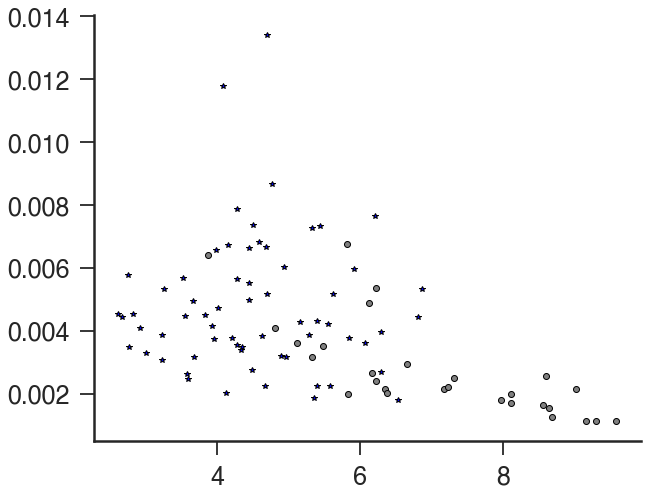

In [157]:
f, ax = plt.subplots()

for osc, vz, class_ in zip(square_w, square_vz, square_feat_class):
# for osc, vz, class_ in zip(square_w, square_vz, square_human_class):
    if class_==1:
        ax.plot(osc, vz, 'o', markeredgecolor='black', color='grey')
    elif class_==2:
        ax.plot(osc, vz, '*', markeredgecolor='black', color='blue')
    else:
        pass
#         ax.plot(osc, vz, 's', markeredgecolor='black', color='red')
    
f.tight_layout()

## Complexity-entropy or Fisher-Shannon plane

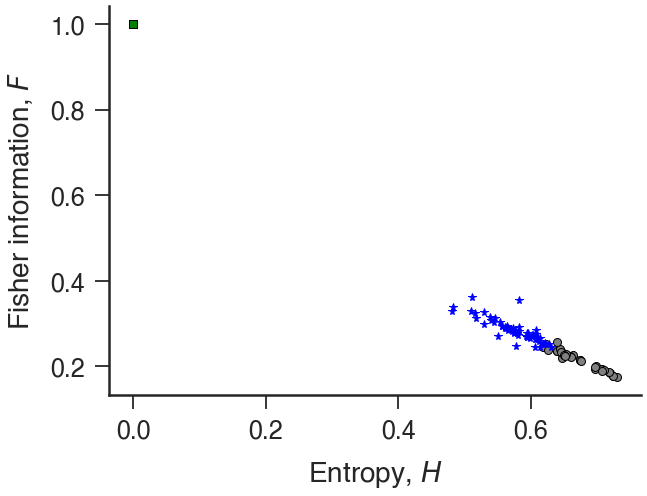

In [65]:
dx_  = 3

square_ce    = []
square_plane = []
for i, st, ts1, ts2, class_ in zip(range(len(square_trajectories)), square_trajectories, 
                                   square_cam1, square_cam2, square_feat_class):
    if class_==3:
        try:
            ts = np.stack((normalize(ts1), normalize(ts2)), axis=1)
            square_ce.append(fisher_shannon(ts, dx=dx_, multi=True))
        except:
            square_ce.append((np.nan, np.nan))
    else:
        ts = np.stack((normalize(ts1), normalize(ts2)), axis=1)
        square_ce.append(fisher_shannon(ts, dx=dx_, multi=True))
        square_plane.append(fisher_shannon(ts, dx=dx_, multi=True))


#         p  = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
#         square_ce.append(ordpy.complexity_entropy(p, dx=dx_, probs=True))
        
        
#         square_ce.append(fisher_shannon(normalize(ts1), dx=dx_, multi=False))


f, ax = plt.subplots()

for (h_, c_), class_ in zip(square_ce, square_feat_class): 
# for (h_, c_), class_ in zip(square_ce, square_human_class):
    if class_ == 1: #tumbling
        ax.plot(h_, c_, '.', marker='o', markersize=8, markeredgecolor='black', color='grey', zorder=0)
    elif class_ == 2: #chaotic
        ax.plot(h_,c_,  '.', marker='*', markersize=8, color='blue')
    if class_ == 3:
        try:
            ax.plot(h_,c_,  '.', marker='s', markersize=8, markeredgecolor='black', color='green', zorder=0)
        except:
            pass

ax.set_ylabel('Fisher information, $F$')
ax.set_xlabel('Entropy, $H$')

f.tight_layout()
# f.savefig('figures/auto-Fisher/Fisher-{}-dx:{}-dims:{}'.format(shape, dx_, dims), bbox_inches='tight')

In [66]:
square_plane = np.asarray(square_plane).reshape(-1,2)
Y_pred       = KMeans(n_clusters=2, random_state=42).fit(square_plane).labels_

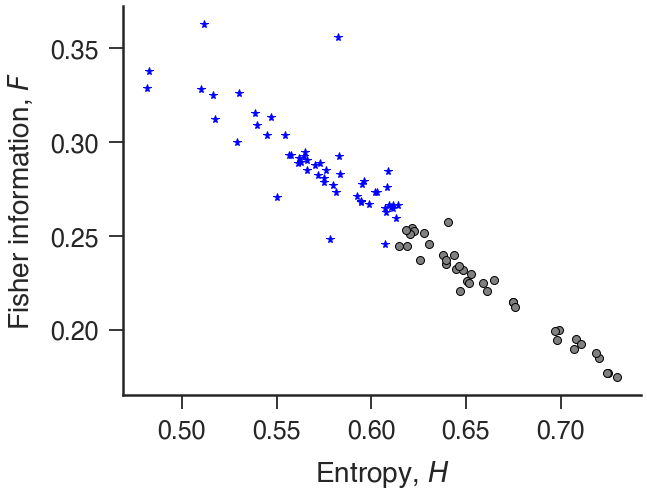

In [67]:
# Only tumbling and chaotic. Observing the frontier in the Fisher x Shannon plane
f, ax = plt.subplots()

for (h_, c_), class_ in zip(square_plane, Y_pred):
    if class_==0:
        ax.plot(h_, c_, '.', marker='o', markersize=8, markeredgecolor='black', color='grey', zorder=0)
    else:
        ax.plot(h_,c_,  '.', marker='*', markersize=8, color='blue')
        
ax.set_ylabel('Fisher information, $F$')
ax.set_xlabel('Entropy, $H$')

f.tight_layout()

In [68]:
Y_pred_full = square_feat_class.copy()
y_pred_sub  = np.where(Y_pred==1, 2, Y_pred)
y_pred_sub  = np.where(y_pred_sub==0, 1, y_pred_sub)

k = 0
for i, j in zip(square_feat_class, range(len(square_feat_class))):
    if i==3:
        pass
    else:
        Y_pred_full[j] = y_pred_sub[k]
        k += 1

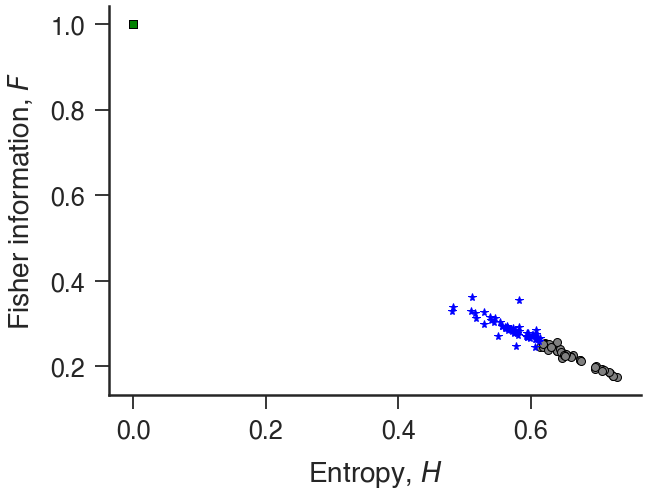

In [69]:
f, ax = plt.subplots()

# for (h_, c_), class_ in zip(square_ce, square_feat_class): 

for (h_, c_), class_ in zip(square_ce, Y_pred_full):
    if class_ == 1: #tumbling
        ax.plot(h_, c_, '.', marker='o', markersize=8, markeredgecolor='black', color='grey', zorder=0)
    elif class_ == 2: #chaotic
        ax.plot(h_,c_,  '.', marker='*', markersize=8, color='blue')
    if class_ == 3:
        try:
            ax.plot(h_,c_,  '.', marker='s', markersize=8, markeredgecolor='black', color='green', zorder=0)
        except:
            pass

ax.set_ylabel('Fisher information, $F$')
ax.set_xlabel('Entropy, $H$')

f.tight_layout()

In [70]:
sum(square_feat_class==square_human_class)/len(square_human_class)

0.889763779527559

In [71]:
sum(Y_pred_full==square_human_class)/len(square_human_class)

0.8740157480314961

## Dimensionality reduction

In [48]:
dx_     = 3
disk_ce = []

square_series_distributions = []
for i, ts1, ts2, class_ in zip(range(len(square_cam1)), square_cam1, 
                                   square_cam2, square_feat_class):
    ts = np.stack((normalize(ts1), normalize(ts2)), axis=1)
    square_series_distributions.append(full_ordinal_distribution(ts, dx=dx_, multi=True)[1])

In [37]:
%matplotlib notebook

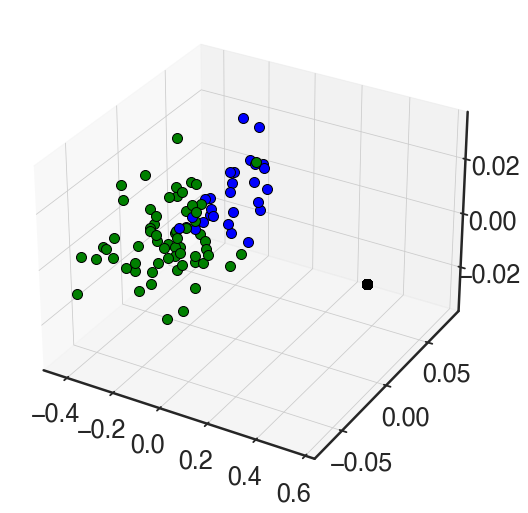

In [50]:
npca = 3
X    = square_series_distributions
Y    = square_human_class


# X_pca      = TSNE(n_components=npca, perplexity=5).fit_transform(X)

# X_pca      = UMAP(n_neighbors=5, n_components=npca).fit_transform(X)

fitted_pca = PCA(n_components=npca).fit(X)
X_pca      = fitted_pca.transform(X)
fitted_pca.explained_variance_ratio_.sum()

f   = plt.figure()
ax  = f.add_subplot(111, projection='3d')

xyz = X_pca

for (x_, y_, z_), class_ in zip(xyz, Y):
    if class_==1:
        ax.scatter(x_, y_, z_, marker='o', s=100, color='blue', edgecolor='black')
    elif class_==2:
        ax.scatter(x_, y_, z_, marker='o', s=100, color='green', edgecolor='black')        
    else:
        ax.scatter(x_, y_, z_, marker='o', s=100, color='black', edgecolor='black')

# ax.set_ylabel("PCA 2")
# ax.set_xlabel("PCA 1")
# ax.set_zlabel('PCA 3')

f.tight_layout()
# f.savefig()

[0.015,
 0.028,
 0.043,
 0.049,
 0.016,
 0.028,
 0.028,
 0.05,
 0.031,
 0.019,
 0.02,
 0.02,
 0.033,
 0.023,
 0.023,
 0.038,
 0.02,
 0.02,
 0.031,
 0.031,
 0.042,
 0.027,
 0.027,
 0.033,
 0.034,
 0.034,
 0.036,
 0.036,
 0.016,
 0.028,
 0.028,
 0.017,
 0.017,
 0.028,
 0.028,
 0.05,
 0.042,
 0.042,
 0.019,
 0.036,
 0.017,
 0.037,
 0.037,
 0.021,
 0.021,
 0.031,
 0.046,
 0.046,
 0.017,
 0.038,
 0.038,
 0.039,
 0.039,
 0.035,
 0.047,
 0.028,
 0.045,
 0.022,
 0.045,
 0.05,
 0.05,
 0.041,
 0.041,
 0.028,
 0.028,
 0.046,
 0.048,
 0.03,
 0.043,
 0.043,
 0.046,
 0.03,
 0.031,
 0.031,
 0.019,
 0.03,
 0.03,
 0.015,
 0.025,
 0.025,
 0.035,
 0.028,
 0.036,
 0.043,
 0.043,
 0.02,
 0.046,
 0.046,
 0.018,
 0.015,
 0.028,
 0.042,
 0.042,
 0.042,
 0.031,
 0.036,
 0.036,
 0.035,
 0.016,
 0.037,
 0.026,
 0.02,
 0.03,
 0.03,
 0.016,
 0.016,
 0.017,
 0.018,
 0.019,
 0.019,
 0.05,
 0.039,
 0.039,
 0.042,
 0.042,
 0.04,
 0.028,
 0.032,
 0.038,
 0.038,
 0.038,
 0.031,
 0.031,
 0.042,
 0.032,
 0.02,
 0.02]

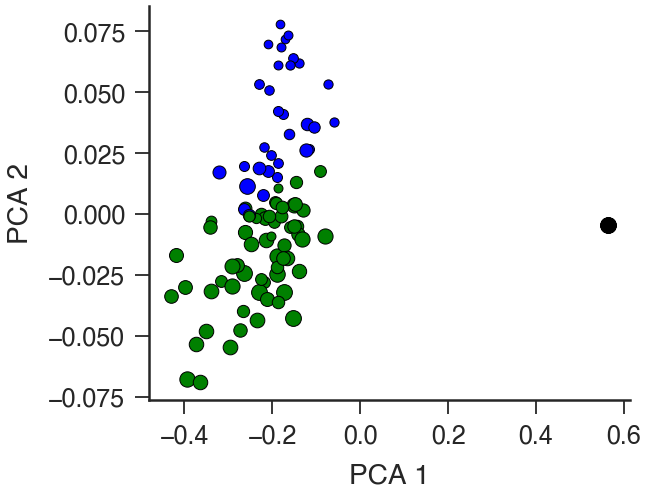

In [59]:
X = square_series_distributions
Y = square_feat_class

npca       = 2
# X_pca      = TSNE(n_components=npca, perplexity=5).fit_transform(X)
# X_pca      = umap.UMAP(n_neighbors=3, n_components=npca).fit_transform(X)
fitted_pca = PCA(n_components=npca).fit(X)
X_pca      = fitted_pca.transform(X)

fitted_pca.explained_variance_ratio_.sum()

f, ax = plt.subplots()

xy = X_pca

for (x_, y_), class_, size_ in zip(xy, Y, square_radii):
    if class_==1:
        ax.scatter(x_, y_, marker='o', s=5000*size_, color='blue', edgecolor='black')
    elif class_==2:
        ax.scatter(x_, y_, marker='o', s=5000*size_, color='green', edgecolor='black')        
    else:
        ax.scatter(x_, y_, marker='o', s=5000*size_, color='black', edgecolor='black')

ax.set_ylabel("PCA 2")
ax.set_xlabel("PCA 1")

f.tight_layout()

# Crosses

In [63]:
#loading cleaned trajectories and some features.
cross_trajectories, cross_cam1, cross_cam2, cross_radius, cross_width, cross_conditions, _ = trajectory_cleaning('Cross')
cross_dx, cross_dy, cross_dz, cross_pathlen, cross_time, cross_w, cross_vz                 = original_features(cross_trajectories, cross_cam1, cross_cam2)

In [64]:
#Classifications
cross_human_class = scipy.io.loadmat('classification/humanClassification{}.mat'.format('Cross'))['behaviourHuman'][0]
cross_feat_class  = scipy.io.loadmat('classification/data{}Classified.mat'.format('Cross'))['behaviourAuto'].flatten()

#Mapping from integer to behavior class
# 1 - Tumbling
# 2 - Chaotic
# 3 - Steady or periodic behavior

In [76]:
# for a, b, c, d, e, f, g,  k in zip(scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['dx'].flatten()==np.asarray(cross_dx), 
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['dy'].flatten()==np.asarray(cross_dy), 
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['dz'].flatten()==np.asarray(cross_dz), 
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['pathLength'].flatten(), cross_pathlen,
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['time'].flatten(), cross_time,
#                             range(len(cross_dx))):

#     print(a, b, c, abs(d-e)<0.0001, abs(f-g)<0.0001, k)

## Original features plane

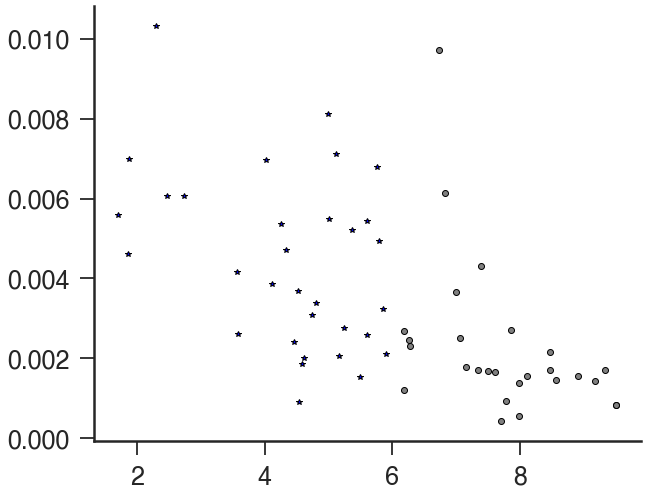

In [158]:
f, ax = plt.subplots()

for osc, vz, class_ in zip(cross_w, cross_vz, cross_feat_class):
# for osc, vz, class_ in zip(cross_w, cross_vz, cross_human_class):
    if class_==1:
        ax.plot(osc, vz, 'o', markeredgecolor='black', color='grey')
    elif class_==2:
        ax.plot(osc, vz, '*', markeredgecolor='black', color='blue')
    else:
        pass
#         ax.plot(osc, vz, 's', markeredgecolor='black', color='red')
    
f.tight_layout()

## Complexity-entropy or Fisher-Shannon plane

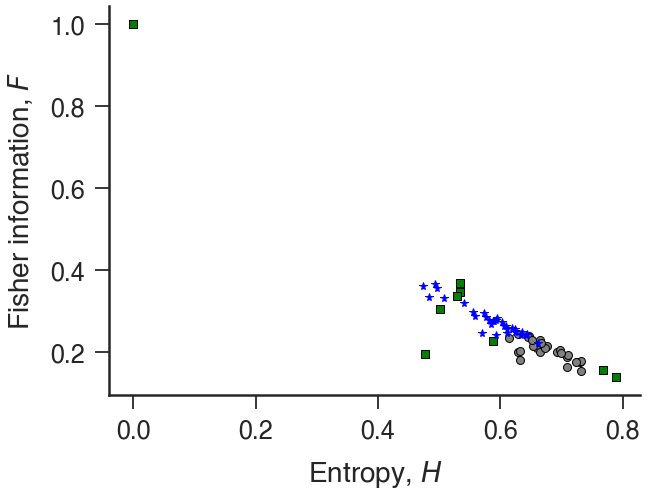

In [147]:
dx_  = 3

cross_ce    = []
cross_plane = []
for i, st, ts1, ts2, class_ in zip(range(len(cross_trajectories)), cross_trajectories, 
                                   cross_cam1, cross_cam2, cross_feat_class):
    if class_==3:
        try:
            ts = np.stack((normalize(ts1), normalize(ts2)), axis=1)
            p  = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
#             cross_ce.append(ordpy.complexity_entropy(p, dx=dx_, probs=True))
            cross_ce.append(fisher_shannon(ts, dx=dx_, multi=True))
        except:
            cross_ce.append((np.nan, np.nan))
    else:
        ts = np.stack((normalize(ts1), normalize(ts2)), axis=1)
        cross_ce.append(fisher_shannon(ts, dx=dx_, multi=True))
        cross_plane.append(fisher_shannon(ts, dx=dx_, multi=True))
        
#         p  = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
#         cross_ce.append(ordpy.complexity_entropy(p, dx=dx_, probs=True))
#         cross_plane.append(ordpy.complexity_entropy(p, dx=dx_, probs=True))


#         p  = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
#         cross_ce.append(ordpy.complexity_entropy(p, dx=dx_, probs=True))
        
        
#         cross_ce.append(fisher_shannon(normalize(ts1), dx=dx_, multi=False))


f, ax = plt.subplots()

for (h_, c_), class_ in zip(cross_ce, cross_feat_class): 
# for (h_, c_), class_ in zip(cross_ce, cross_human_class):
    if class_ == 1: #tumbling
        ax.plot(h_, c_, '.', marker='o', markersize=8, markeredgecolor='black', color='grey', zorder=0)
    elif class_ == 2: #chaotic
        ax.plot(h_,c_,  '.', marker='*', markersize=8, color='blue')
    if class_ == 3:
        try:
            ax.plot(h_,c_,  '.', marker='s', markersize=8, markeredgecolor='black', color='green', zorder=0)
        except:
            pass

ax.set_ylabel('Fisher information, $F$')
ax.set_xlabel('Entropy, $H$')

f.tight_layout()
# f.savefig('figures/auto-Fisher/Fisher-{}-dx:{}-dims:{}'.format(shape, dx_, dims), bbox_inches='tight')

In [148]:
cross_plane  = np.asarray(cross_plane).reshape(-1,2)
Y_pred       = KMeans(n_clusters=2, random_state=42).fit(cross_plane).labels_

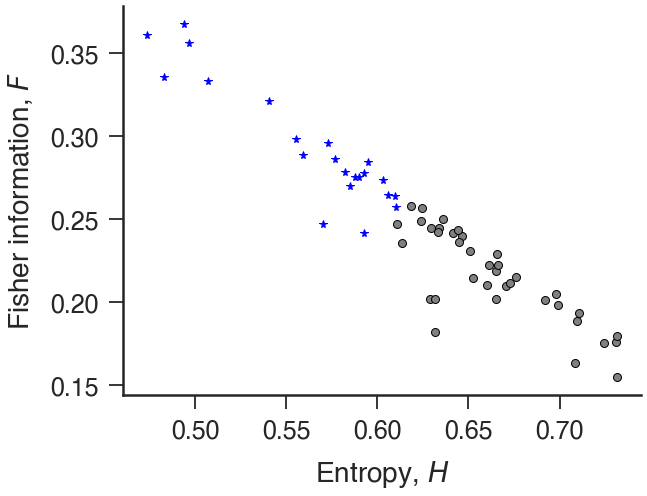

In [149]:
# Only tumbling and chaotic. Observing the frontier in the Fisher x Shannon plane
f, ax = plt.subplots()

for (h_, c_), class_ in zip(cross_plane, Y_pred):
    if class_==0:
        ax.plot(h_, c_, '.', marker='o', markersize=8, markeredgecolor='black', color='grey', zorder=0)
    else:
        ax.plot(h_,c_,  '.', marker='*', markersize=8, color='blue')
        
ax.set_ylabel('Fisher information, $F$')
ax.set_xlabel('Entropy, $H$')

f.tight_layout()

In [150]:
Y_pred_full = cross_feat_class.copy()
y_pred_sub  = np.where(Y_pred==1, 2, Y_pred)
y_pred_sub  = np.where(y_pred_sub==0, 1, y_pred_sub)

k = 0
for i, j in zip(cross_feat_class, range(len(cross_feat_class))):
    if i==3:
        pass
    else:
        Y_pred_full[j] = y_pred_sub[k]
        k += 1

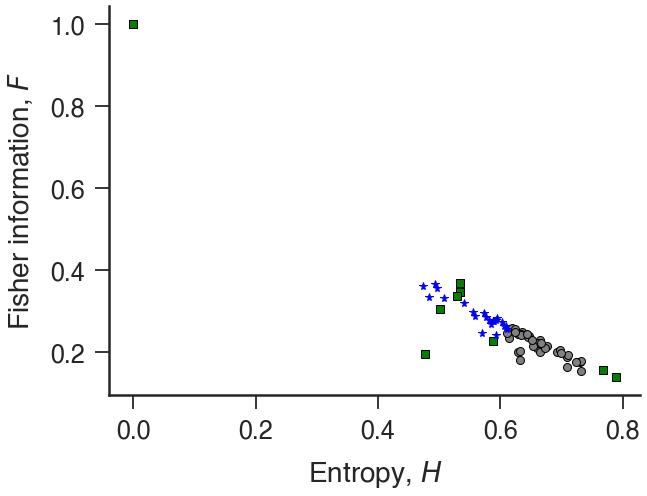

In [151]:
f, ax = plt.subplots()

# for (h_, c_), class_ in zip(cross_ce, cross_feat_class): 

for (h_, c_), class_ in zip(cross_ce, Y_pred_full):
    if class_ == 1: #tumbling
        ax.plot(h_, c_, '.', marker='o', markersize=8, markeredgecolor='black', color='grey', zorder=0)
    elif class_ == 2: #chaotic
        ax.plot(h_,c_,  '.', marker='*', markersize=8, color='blue')
    if class_ == 3:
        try:
            ax.plot(h_,c_,  '.', marker='s', markersize=8, markeredgecolor='black', color='green', zorder=0)
        except:
            pass

ax.set_ylabel('Fisher information, $F$')
ax.set_xlabel('Entropy, $H$')

f.tight_layout()

In [152]:
sum(cross_feat_class==cross_human_class)/len(cross_human_class)

0.7162162162162162

In [153]:
sum(Y_pred_full==cross_human_class)/len(cross_human_class)

0.6351351351351351

## Dimensionality reduction

In [21]:
dx_     = 3
disk_ce = []

cross_series_distributions = []
for i, ts1, ts2, class_ in zip(range(len(cross_cam1)), cross_cam1, 
                                   cross_cam2, cross_feat_class):
    ts = np.stack((normalize(ts1), normalize(ts2)), axis=1)
    cross_series_distributions.append(full_ordinal_distribution(ts, dx=dx_, multi=True)[1])

In [25]:
npca = 3
X    = cross_series_distributions
Y    = cross_human_class


# X_pca      = TSNE(n_components=npca, perplexity=5).fit_transform(X)

# X_pca      = UMAP(n_neighbors=5, n_components=npca).fit_transform(X)

fitted_pca = PCA(n_components=npca).fit(X)
X_pca      = fitted_pca.transform(X)
fitted_pca.explained_variance_ratio_.sum()

0.9959945537823508

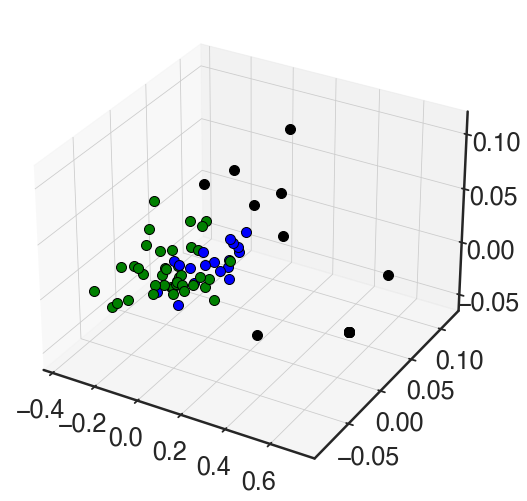

In [26]:
f   = plt.figure()
ax  = f.add_subplot(111, projection='3d')

xyz = X_pca

for (x_, y_, z_), class_ in zip(xyz, Y):
    if class_==1:
        ax.scatter(x_, y_, z_, marker='o', s=100, color='blue', edgecolor='black')
    elif class_==2:
        ax.scatter(x_, y_, z_, marker='o', s=100, color='green', edgecolor='black')        
    else:
        ax.scatter(x_, y_, z_, marker='o', s=100, color='black', edgecolor='black')

# ax.set_ylabel("PCA 2")
# ax.set_xlabel("PCA 1")
# ax.set_zlabel('PCA 3')

f.tight_layout()
# f.savefig()

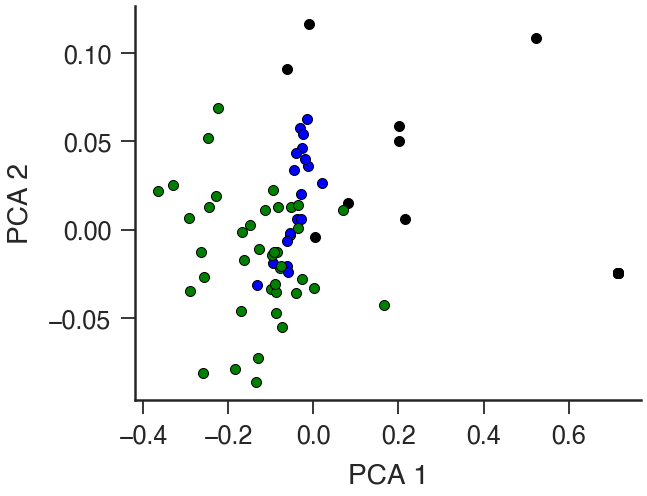

In [63]:
X = cross_series_distributions
Y = cross_human_class

npca       = 2
# X_pca      = TSNE(n_components=npca, perplexity=5).fit_transform(X)
# X_pca      = umap.UMAP(n_neighbors=3, n_components=npca).fit_transform(X)
fitted_pca = PCA(n_components=npca).fit(X)
X_pca      = fitted_pca.transform(X)

fitted_pca.explained_variance_ratio_.sum()

f, ax = plt.subplots()

xy = X_pca

for (x_, y_), class_ in zip(xy, Y):
    if class_==1:
        ax.scatter(x_, y_, marker='o', s=100, color='blue', edgecolor='black')
    elif class_==2:
        ax.scatter(x_, y_, marker='o', s=100, color='green', edgecolor='black')        
    else:
        ax.scatter(x_, y_, marker='o', s=100, color='black', edgecolor='black')

ax.set_ylabel("PCA 2")
ax.set_xlabel("PCA 1")

f.tight_layout()

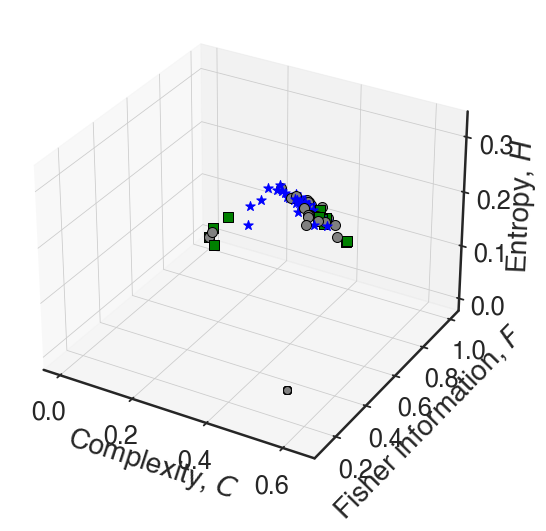

In [206]:
dx_ = 3

pe3d       = []
pe3d_plane = []

for i, st, ts1, ts2, class_ in zip(range(len(cross_trajectories)), cross_trajectories, 
                                   cross_cam1, cross_cam2, cross_feat_class):
    if class_==3:
        try:
            ts = np.stack((normalize(ts1), normalize(ts2)), axis=1)
            p  = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
            h_, f_ = fisher_shannon(p, dx=dx_, probs=True, multi=True)
            _, c_  = ordpy.complexity_entropy(p, dx=dx_, probs=True)
            pe3d.append((h_, f_, c_))
        except:
            cross_ce.append((np.nan, np.nan))
    else:

        ts = np.stack((normalize(ts1), normalize(ts2)), axis=1)
        p  = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
        h_, f_ = fisher_shannon(p, dx=dx_, probs=True, multi=True)
        _, c_  = ordpy.complexity_entropy(p, dx=dx_, probs=True)
        pe3d.append((h_, f_, c_))
        pe3d_plane.append((h_, f_, c_))

f  = plt.figure()
ax = f.add_subplot(111, projection='3d')

#(h_, f_, c_)
for (x_, y_, z_), class_ in zip(pe3d, cross_feat_class): 
# for (x_, y_, z_), class_ in zip(pe3d, cross_human_class):
    if class_ == 1: #tumbling
        ax.scatter(x_, y_, z_, marker='o', s=100, color='grey', edgecolor='black')
        ax.plot(h_, c_, '.', marker='o', markersize=8, markeredgecolor='black', color='grey', zorder=0)
    elif class_ == 2: #chaotic
        ax.scatter(x_, y_, z_, marker='*', s=100, color='blue')        
    if class_ == 3:
        try:
            ax.scatter(x_, y_, z_, marker='s', s=100, color='green', edgecolor='black', zorder=0)
        except:
            pass

ax.set_ylabel('Fisher information, $F$')
ax.set_xlabel('Complexity, $C$')
ax.set_zlabel('Entropy, $H$')

f.tight_layout()

In [191]:
pe3d_plane = np.asarray(pe3d_plane).reshape(-1, 3)
Y_pred     = KMeans(n_clusters=2, random_state=42).fit(pe3d_plane).labels_

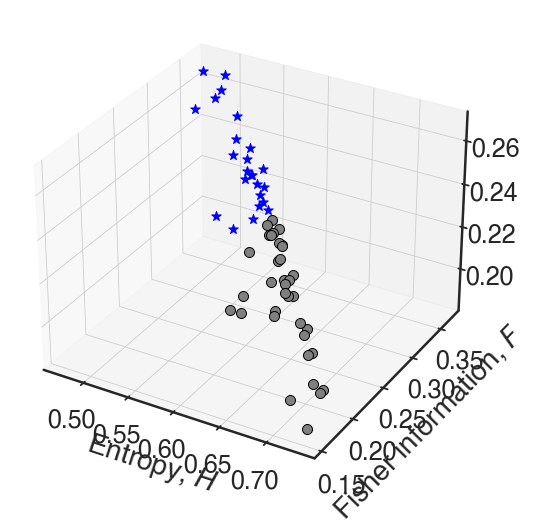

In [192]:
f  = plt.figure()
ax = f.add_subplot(111, projection='3d')


#(h_, f_, c_)
for (h_, f_, c_), class_ in zip(pe3d_plane, Y_pred): 
    if class_==0:
        ax.scatter(h_, f_, c_, marker='o', s=100, edgecolor='black', color='grey', zorder=0)
    else:
        ax.scatter(h_, f_, c_, marker='*', s=100, color='blue')
        
ax.set_ylabel('Fisher information, $F$')
ax.set_xlabel('Entropy, $H$')

f.tight_layout()

In [201]:
Y_pred_full = cross_feat_class.copy()
y_pred_sub  = Y_pred+1
# y_pred_sub  = np.where(Y_pred==0, 2, Y_pred)

k = 0
for i, j in zip(cross_feat_class, range(len(cross_feat_class))):
    if i==3:
        pass
    else:
        Y_pred_full[j] = y_pred_sub[k]
        k += 1

In [196]:
sum(cross_feat_class==cross_human_class)/len(cross_human_class)

0.7162162162162162

In [203]:
sum(Y_pred_full==cross_human_class)/len(cross_human_class)

0.6621621621621622